In [263]:
import json
import os
import csv
import math
import ast 
import pandas as pd
import seaborn as sns

path = 'C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/data/events'
event_files = []
all_files = os.listdir(path)

for i in range(0, len(all_files), 10):
    nom = os.path.join(path, all_files[i])
    if os.path.isfile(nom):
        event_files.append(nom)

# Archivo de salida CSV
output_csv = 'C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shots_data.csv'

# Centro de la portería y campos de interés
goal_center = [120, 40]
fields = [
    'event_id', 'period', 'minute',  
    'team', 'player', 'location', 'shot_distance',
    'shot_angle', 'body_part', 'play_pattern', 'freeze_frame', 
    'technique', 'statsbomb_xg', 'type', 'aerial_won', 'open_goal'
]

with open(output_csv, mode='w', newline='', encoding='utf-8') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fields)
    writer.writeheader()

    for file_path in event_files:
        with open(file_path, 'r', encoding='utf-8') as f:
            events = json.load(f)
            
            match_id = os.path.basename(file_path).replace('.json', '')
            
            for event in events:
                if event.get('type', {}).get('name') == 'Shot':
                    location = event.get('location')
                    aerial_won=event.get('shot', {}).get('aerial_won')
                    open_goal= event.get('shot',{}).get('open_goal')
                    freeze_frame=event.get('shot', {}).get('freeze_frame')
                    if location:
                        # Calcular distancia euclidiana a la portería (hipotenusa)
                        shot_distance = math.sqrt((goal_center[0] - location[0]) ** 2 + (goal_center[1] - location[1]) ** 2)
                        
                        # Calcular distancia horizontal (lado adyacente)
                        adj_side = abs(goal_center[0] - location[0])
                        
                        # Calcular ángulo del tiro usando el arcocoseno
                        if shot_distance != 0:
                            shot_angle = math.degrees(math.acos(adj_side / shot_distance))
                        else:
                            shot_angle = None
                    else:
                        shot_distance = None
                        shot_angle = None
                    if aerial_won:
                        aerial_won=1
                    else:
                        aerial_won=0
                    if open_goal:
                        open_goal=1
                    else:
                        open_goal=0 
                    if (freeze_frame is None)or (type(freeze_frame)==list and len(freeze_frame)==0):
                        freeze_frame=0
                    else:
                        freeze_frame=freeze_frame

                    shot_data = {
                        'event_id': event.get('id'),
                        'period': event.get('period'),
                        'minute': event.get('minute'),
                        'team': event.get('team', {}).get('name'),
                        'player': event.get('player', {}).get('name'),
                        'location': location,
                        'shot_distance': shot_distance,
                        'shot_angle': shot_angle,
                        'body_part':event.get('shot', {}).get('body_part', {}).get('name'),
                        'play_pattern': event.get('play_pattern', {}).get('name'),
                        'freeze_frame': freeze_frame,
                        'technique': event.get('shot', {}).get('technique', {}).get('name'),
                        'statsbomb_xg': event.get('shot', {}).get('statsbomb_xg'),
                        'type': event.get('shot', {}).get('type', {}).get('name'),
                        'aerial_won': aerial_won,
                        'open_goal': open_goal
                    }
                    
                    writer.writerow(shot_data)

print(f"Datos de remates extraídos y guardados en {output_csv}")

Datos de remates extraídos y guardados en C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shots_data.csv


In [264]:
#TO DO: EXPLICAR EL MOTIU DE ast.literal_eval

In [265]:
import pandas as pd
import ast

output_csv = 'C:/Users/eloim/OneDrive/Escritorio/3 er carrera/apc/cas kaggle/open-data-master/open-data-master/shots_data.csv'
df = pd.read_csv(output_csv)

def convert_freeze_frame(value):
    try:
        if value == "0":  
            return []
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return None

df['freeze_frame'] = df['freeze_frame'].apply(convert_freeze_frame)


In [266]:
def calcular_distancia(punt1, punt2):
    return math.sqrt((punt2[0] - punt1[0]) ** 2 + (punt2[1] - punt1[1]) ** 2)


def calcular_angle(origen, punt1, punt2):
    if(origen!=None and punt1!=None and punt2!=None):
        vector1 = (punt1[0] - origen[0], punt1[1] - origen[1])
        vector2 = (punt2[0] - origen[0], punt2[1] - origen[1])
        producto_escalar = vector1[0] * vector2[0] + vector1[1] * vector2[1]
        magnitud1 = math.sqrt(vector1[0] ** 2 + vector1[1] ** 2)
        magnitud2 = math.sqrt(vector2[0] ** 2 + vector2[1] ** 2)
        if magnitud1 == 0 or magnitud2 == 0:
            return None
        cos_angulo = producto_escalar / (magnitud1 * magnitud2)
        angulo = math.acos(max(min(cos_angulo, 1), -1))  
        return math.degrees(angulo)
    else:
        return 0

In [267]:
for i in range(len(df)):
    aux=df['freeze_frame'][i]
    posicio_rematador=ast.literal_eval(df['location'][i])
    for jugador in aux:
        if jugador['position']['name']=='Goalkeeper':
            posicio_porter= jugador['location']
    for idx, jugador in enumerate([j for j in df['freeze_frame'][i] if j['teammate']==False]):
        posicio_rival=jugador['location']
        distancia=calcular_distancia(posicio_rematador, posicio_rival)
        angle_rematador_rival_porter = calcular_angle(posicio_porter, posicio_rival, posicio_rematador)
        df.at[i,'distancia jugador'+" "+str(idx)]=distancia
        df.at[i,'angle jugador'+" "+str(idx)]=angle_rematador_rival_porter
        

df.to_csv(output_csv, index=False)
print(df['distancia jugador 8'][1])   


4.976946855251725


In [268]:
#TO DO:INSPECCIÓ NANS ANGLES:

In [269]:
missing_values = df.isnull().sum()
print(missing_values)

event_id                   0
period                     0
minute                     0
team                       0
player                     0
location                   0
shot_distance              0
shot_angle                 0
body_part                  0
play_pattern               0
freeze_frame               0
technique                  0
statsbomb_xg               0
type                       0
aerial_won                 0
open_goal                  0
distancia jugador 0      117
angle jugador 0         2769
distancia jugador 1      132
angle jugador 1          809
distancia jugador 2      147
angle jugador 2          615
distancia jugador 3      238
angle jugador 3          656
distancia jugador 4      435
angle jugador 4          887
distancia jugador 5      809
angle jugador 5         1356
distancia jugador 6     1445
angle jugador 6         2121
distancia jugador 7     2494
angle jugador 7         3243
distancia jugador 8     4008
angle jugador 8         4793
distancia juga

Com podem veure, tot i que el nombre de nans entre "distancia jugador i" i "angle jugador i" hauria de coincidir, als angles tenen bastants mes Nans en comparació amb les distàncies, especialment en els primers registres. Anem a veure què pot estar passant prenent com mostra l'angle del jugador 0 (característica on es dona més el fenòmen i on hi ha una clara evidència de que no és casualitat)

In [270]:
llista=[j for j in range(len(df)) if pd.isnull(df['angle jugador 0'][j])]
inspeccio=[]
for i in llista:
    if (len(df['freeze_frame'][i])>0):
        inspeccio.append(df['freeze_frame'][i][0]['position']['name'])
        
unic = set(inspeccio)  
position_counts = {position:inspeccio.count(position) for position in unic}
ordenat=dict(sorted(position_counts.items(), key=lambda item: item[1], reverse=True))
for i,j in ordenat.items():
    print(i,":",j)
    

Goalkeeper : 1667
Center Forward : 127
Right Wing : 102
Left Wing : 82
Left Back : 71
Left Center Midfield : 67
Right Back : 63
Right Center Midfield : 56
Left Midfield : 47
Right Defensive Midfield : 46
Center Attacking Midfield : 46
Left Defensive Midfield : 45
Right Center Forward : 44
Left Center Forward : 40
Right Midfield : 35
Right Center Back : 28
Left Center Back : 26
Left Wing Back : 19
Center Defensive Midfield : 14
Right Wing Back : 14
Right Attacking Midfield : 5
Center Back : 4
Left Attacking Midfield : 4


Com podem comprovar la majoria dels valor Nans de l'angle del jugador 0 són en porters ja que la funció calcular_angle agafa com a origen la posició del porter, aleshores, com hem establert en la funció, l'angle que formarà el porter amb el rematador agafant la posició del guardameta com a origen serà None.
A continuació omplenarem aquests valors per l'angle que es forma entre el porter i el rematador respecte el centre de la porteria. En cas que el porter estigui exactament al centre de la porteria assignarem l'angle calculat al principi "shot_angle" que equival a l'angle format entre el rematador i el centre de la porteria (on està ara el porter).

In [271]:
#ASSIGNAR NANS

In [272]:
for i in range(len(df)):
    aux=df['freeze_frame'][i]
    posicio_rematador=ast.literal_eval(df['location'][i])
    for idx, jugador in enumerate([j for j in df['freeze_frame'][i] if j['teammate']==False]):
        posicio_rival=jugador['location']
        distancia=calcular_distancia(posicio_rematador, posicio_rival)
        angle_rematador_porter_porteria = calcular_angle(goal_center, posicio_rival, posicio_rematador)
        if jugador['position']['name']=='Goalkeeper'and posicio_rival!=goal_center:
            df.at[i,'distancia jugador'+" "+str(idx)]=distancia
            df.at[i,'angle jugador'+" "+str(idx)]= angle_rematador_porter_porteria
        elif jugador['position']['name']=='Goalkeeper'and posicio_rival==goal_center:
            df.at[i,'distancia jugador'+" "+str(idx)]=distancia
            df.at[i,'angle jugador'+" "+str(idx)]= df['shot_angle'][i]
df.to_csv(output_csv, index=False)

In [273]:
missing_values = df.isnull().sum()
print(missing_values)

event_id                   0
period                     0
minute                     0
team                       0
player                     0
location                   0
shot_distance              0
shot_angle                 0
body_part                  0
play_pattern               0
freeze_frame               0
technique                  0
statsbomb_xg               0
type                       0
aerial_won                 0
open_goal                  0
distancia jugador 0      117
angle jugador 0          117
distancia jugador 1      132
angle jugador 1          132
distancia jugador 2      147
angle jugador 2          147
distancia jugador 3      238
angle jugador 3          238
distancia jugador 4      435
angle jugador 4          435
distancia jugador 5      809
angle jugador 5          809
distancia jugador 6     1445
angle jugador 6         1445
distancia jugador 7     2494
angle jugador 7         2494
distancia jugador 8     4008
angle jugador 8         4008
distancia juga

In [274]:
#Explicar per què assignem 0 als jugadors per darrera la pilota a una certa distància i per què assignem 0 als Nans.

In [275]:
for i in range(len(df)):
    aux=df['freeze_frame'][i]
    posicio_rematador=ast.literal_eval(df['location'][i])
    for idx, jugador in enumerate([j for j in df['freeze_frame'][i] if j['teammate']==False]):
        posicio_rival=jugador['location']
        distancia=calcular_distancia(posicio_rematador, posicio_rival)
        angle_rematador_rival_porter = calcular_angle(posicio_porter, posicio_rival, posicio_rematador)
        if(posicio_rival[0]<posicio_rematador[0] and distancia>=2):
            df.at[i,'distancia jugador'+" "+str(idx)]=0
            df.at[i,'angle jugador'+" "+str(idx)]=0

df.dropna(axis=1, thresh=len(df) * 0.5, inplace=True)  
df.fillna(0, inplace=True)

In [276]:
"""
for idx, row in df.iterrows():
    posicio_rematador = ast.literal_eval(row['location'])  
    freeze_frame= row['freeze_frame']
    for jugador in freeze_frame:
        if jugador['position']['name']=='Goalkeeper':
            posicio_porter= jugador['location']
    for i,jugador in zip(range(len(freeze_frame)),freeze_frame):
        if jugador['teammate']==False:
            posicio_rival=jugador['location']
            distancia=calcular_distancia(posicio_rematador, posicio_rival)
            angle_rematador_rival = calcular_angle(posicio_rival, posicio_rematador, posicio_rival)
            angle_remtador_rival_porter = calcular_angle(posicio_porter, posicio_rival, posicio_rematador)
            df.at[idx,'distancia jugador'+str(i)]=distancia
            df.at[idx,'angle jugador'+str(i)]=angle_rematador_rival
            
            
            

        
        
    
    
    
print(df['distancia jugador2'])
print(df.head())
print(element['location'])

"""

"\nfor idx, row in df.iterrows():\n    posicio_rematador = ast.literal_eval(row['location'])  \n    freeze_frame= row['freeze_frame']\n    for jugador in freeze_frame:\n        if jugador['position']['name']=='Goalkeeper':\n            posicio_porter= jugador['location']\n    for i,jugador in zip(range(len(freeze_frame)),freeze_frame):\n        if jugador['teammate']==False:\n            posicio_rival=jugador['location']\n            distancia=calcular_distancia(posicio_rematador, posicio_rival)\n            angle_rematador_rival = calcular_angle(posicio_rival, posicio_rematador, posicio_rival)\n            angle_remtador_rival_porter = calcular_angle(posicio_porter, posicio_rival, posicio_rematador)\n            df.at[idx,'distancia jugador'+str(i)]=distancia\n            df.at[idx,'angle jugador'+str(i)]=angle_rematador_rival\n            \n            \n            \n\n        \n        \n    \n    \n    \nprint(df['distancia jugador2'])\nprint(df.head())\nprint(element['location'])

In [277]:
#TO DO: EXPLICAR CALCUL DELS ANGLES DELS RIVALS RESPECTE LA PILOTA DEL JUGADOR QUE REMATA I DE LA DISTANCIA

In [278]:
""""import math
import pandas as pd
import ast


def calcular_distancia(punto1, punto2):
    return math.sqrt((punto2[0] - punto1[0]) ** 2 + (punto2[1] - punto1[1]) ** 2)


def calcular_angle(origen, punto1, punto2):
    if(origen!=None and punto1!=None and punto2!=None):
        vector1 = (punto1[0] - origen[0], punto1[1] - origen[1])
        vector2 = (punto2[0] - origen[0], punto2[1] - origen[1])
        producto_escalar = vector1[0] * vector2[0] + vector1[1] * vector2[1]
        magnitud1 = math.sqrt(vector1[0] ** 2 + vector1[1] ** 2)
        magnitud2 = math.sqrt(vector2[0] ** 2 + vector2[1] ** 2)
        if magnitud1 == 0 or magnitud2 == 0:
            return None
        cos_angulo = producto_escalar / (magnitud1 * magnitud2)
        angulo = math.acos(max(min(cos_angulo, 1), -1))  
        return math.degrees(angulo)
    else:
        return 0


for index, row in df.iterrows():
    posicion_rematador = ast.literal_eval(row['location'])  

    freeze_frame = row['freeze_frame']  
    nuevos_datos = []

    posicion_portero = None
    for jugador in freeze_frame:
        if jugador.get('position', {}).get('name') == 'Goalkeeper':
            posicion_portero = jugador.get('location', [None, None])
            break

    if posicion_portero is None:
        continue

    for idx, jugador in enumerate(freeze_frame):
        print(idx)
        if not jugador.get('teammate', True):
            posicion_rival = jugador.get('location', [None, None])
            if None in posicion_rival:
                continue  
            distancia_al_balon = calcular_distancia(posicion_rematador, posicion_rival)
            angulo_rematador_desde_rival = calcular_angulo(posicion_rival, posicion_rematador, posicion_rival)
            angulo_rival_desde_portero = calcular_angulo(posicion_portero, posicion_rival, posicion_rematador)

            nuevo_jugador = {
                'location': posicion_rival,
                'distancia_al_balon': distancia_al_balon,
                'angulo_rematador_desde_rival': angulo_rematador_desde_rival,
                'angulo_rival_desde_portero': angulo_rival_desde_portero,
            }
            
            nuevos_datos.append(nuevo_jugador)
            print(idx)
            df[str(idx)]=nuevo_jugador

    df.at[index, 'freeze_frame'] = nuevos_datos

df.to_csv(output_csv, index=False)

#print(df['event_id'],df['freeze_frame'][0])
print(df.head()) """

'"import math\nimport pandas as pd\nimport ast\n\n\ndef calcular_distancia(punto1, punto2):\n    return math.sqrt((punto2[0] - punto1[0]) ** 2 + (punto2[1] - punto1[1]) ** 2)\n\n\ndef calcular_angle(origen, punto1, punto2):\n    if(origen!=None and punto1!=None and punto2!=None):\n        vector1 = (punto1[0] - origen[0], punto1[1] - origen[1])\n        vector2 = (punto2[0] - origen[0], punto2[1] - origen[1])\n        producto_escalar = vector1[0] * vector2[0] + vector1[1] * vector2[1]\n        magnitud1 = math.sqrt(vector1[0] ** 2 + vector1[1] ** 2)\n        magnitud2 = math.sqrt(vector2[0] ** 2 + vector2[1] ** 2)\n        if magnitud1 == 0 or magnitud2 == 0:\n            return None\n        cos_angulo = producto_escalar / (magnitud1 * magnitud2)\n        angulo = math.acos(max(min(cos_angulo, 1), -1))  \n        return math.degrees(angulo)\n    else:\n        return 0\n\n\nfor index, row in df.iterrows():\n    posicion_rematador = ast.literal_eval(row[\'location\'])  \n\n    freeze_

In [279]:
#TO DO: EXPLICAR PER QUÈ INVERTIM L'EIX Y (CARACTERÍSTIQUES DEL DATASET)

In [286]:
"""import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_field(ax):
    # Dimensiones del campo
    field_length = 120
    field_width = 80

    # Dibujar el contorno del campo
    ax.plot([0, 0, field_length, field_length, 0], [0, field_width, field_width, 0, 0], color="black")
    ax.plot([60, 60], [0, field_width], color="black")

    # Dibujar las áreas de penalti
    ax.plot([0, 18, 18, 0], [18, 18, 62, 62], color="black")  # Área izquierda
    ax.plot([120, 102, 102, 120], [18, 18, 62, 62], color="black")  # Área derecha

    # Dibujar las áreas pequeñas
    ax.plot([0, 6, 6, 0], [30, 30, 50, 50], color="black")  # Área pequeña izquierda
    ax.plot([120, 114, 114, 120], [30, 30, 50, 50], color="black")  # Área pequeña derecha

    # Dibujar los círculos centrales y los puntos de penalti
    center_circle = patches.Circle((60, 40), 10, color="black", fill=False)  # Círculo central
    ax.add_patch(center_circle)
    ax.plot(60, 40, 'o', color="black")  # Centro del campo
    ax.plot(12, 40, 'o', color="black")  # Punto penal izquierdo
    ax.plot(108, 40, 'o', color="black")  # Punto penal derecho

    # Dibujar los arcos de las áreas de penalti
    left_arc = patches.Arc((18, 40), 10, 15, theta1=-90, theta2=90, color="black")
    right_arc = patches.Arc((102, 40), 10,15, theta1=90, theta2=270, color="black")
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)

    # Dibujar los arcos de las porterías
    ax.plot([0, 0], [36, 44], color="black")  # Portería izquierda
    ax.plot([120, 120], [36, 44], color="black")  # Portería derecha

    # Configurar los límites del gráfico
    ax.set_xlim(-5, field_length + 5)
    ax.set_ylim(-5, field_width + 5)
    ax.set_aspect("equal")

    # Invertir el eje Y para que Y=0 esté en la parte superior
    ax.invert_yaxis()

# Coordenadas de los jugadores
x=[]
y=[]
for i in range(len(df)):
    element=df['freeze_frame'][i]
    for jugador in [j for j in element if j['teammate']==False]:
        if(jugador['location'][0]!=None and jugador['location'][1]!=None):
            x.append(jugador['location'][0])
            y.append(jugador['location'][1])

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Dibujar el campo de fútbol
draw_field(ax)

# Poner jugadores en el campo
ax.scatter(x, y, color="blue", s=25, label="Jugadors")  # Plot de jugadores

# Añadir título y leyenda
ax.set_title("Campo de Futbol amb jugadors")
ax.legend()

# Mostrar el gráfico
plt.show()
"""
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_field(ax):
    # Dimensiones del campo
    field_length = 120
    field_width = 80

    # Dibujar el contorno del campo
    ax.plot([0, 0, field_length, field_length, 0], [0, field_width, field_width, 0, 0], color="black")
    ax.plot([60, 60], [0, field_width], color="black")

    # Dibujar las áreas de penalti
    ax.plot([0, 18, 18, 0], [18, 18, 62, 62], color="black")  # Área izquierda
    ax.plot([120, 102, 102, 120], [18, 18, 62, 62], color="black")  # Área derecha

    # Dibujar las áreas pequeñas
    ax.plot([0, 6, 6, 0], [30, 30, 50, 50], color="black")  # Área pequeña izquierda
    ax.plot([120, 114, 114, 120], [30, 30, 50, 50], color="black")  # Área pequeña derecha

    # Dibujar los círculos centrales y los puntos de penalti
    center_circle = patches.Circle((60, 40), 10, color="black", fill=False)  # Círculo central
    ax.add_patch(center_circle)
    ax.plot(60, 40, 'o', color="black")  # Centro del campo
    ax.plot(12, 40, 'o', color="black")  # Punto penal izquierdo
    ax.plot(108, 40, 'o', color="black")  # Punto penal derecho

    # Dibujar los arcos de las áreas de penalti
    left_arc = patches.Arc((18, 40), 10, 15, theta1=-90, theta2=90, color="black")
    right_arc = patches.Arc((102, 40), 10,15, theta1=90, theta2=270, color="black")
    ax.add_patch(left_arc)
    ax.add_patch(right_arc)

    # Dibujar los arcos de las porterías
    ax.plot([0, 0], [36, 44], color="black")  # Portería izquierda
    ax.plot([120, 120], [36, 44], color="black")  # Portería derecha

    # Configurar los límites del gráfico
    ax.set_xlim(-5, field_length + 5)
    ax.set_ylim(-5, field_width + 5)
    ax.set_aspect("equal")

    # Invertir el eje Y para que Y=0 esté en la parte superior
    ax.invert_yaxis()



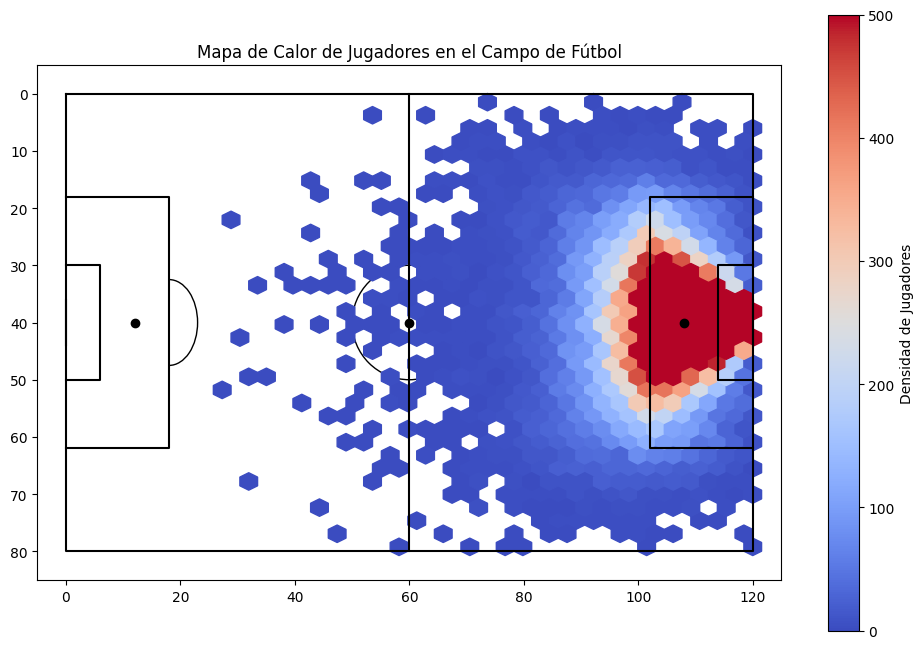

In [335]:
# Coordenadas de los jugadores
x = []
y = []
for i in range(len(df)):
    element = df['freeze_frame'][i]
    for jugador in [j for j in element if j['teammate'] == False]:
        if jugador['location'][0] is not None and jugador['location'][1] is not None:
            x.append(jugador['location'][0])
            y.append(jugador['location'][1])


fig, ax = plt.subplots(figsize=(12, 8))
draw_field(ax)

hb = ax.hexbin(x, y, gridsize=30, cmap='coolwarm', mincnt=1, vmin=0, vmax=500)  # 'YlGnBu' es una escala de color
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Densidad de Jugadores')


ax.set_title("Mapa de Calor de Jugadores en el Campo de Fútbol")
plt.show()


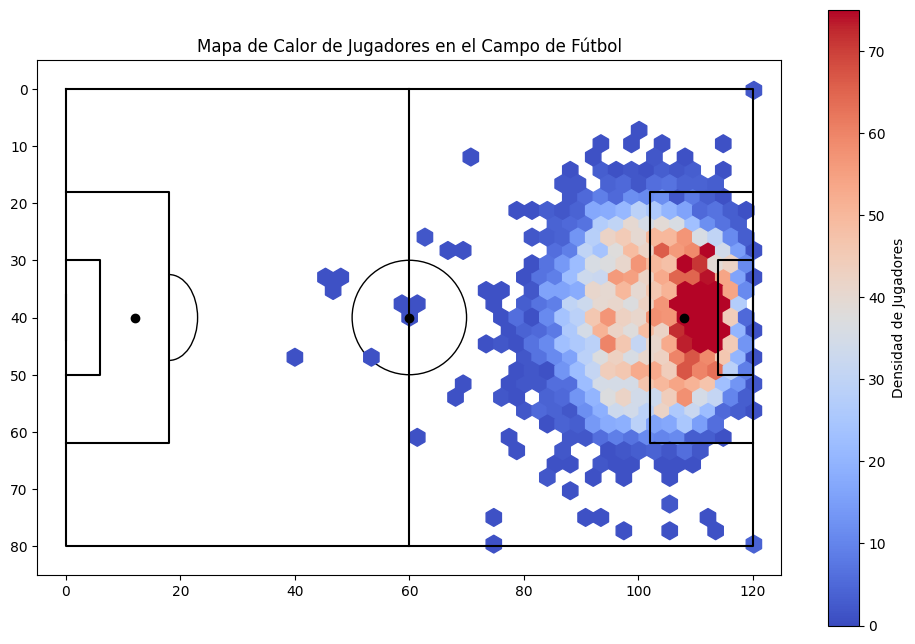

In [333]:
x=[]
y=[]
for i in range(len(df)):
    posicio_rematador=ast.literal_eval(df['location'][i])
    x.append(posicio_rematador[0])
    y.append(posicio_rematador[1])
fig, ax = plt.subplots(figsize=(12, 8))
draw_field(ax)

hb = ax.hexbin(x, y, gridsize=30, cmap='coolwarm', mincnt=1,vmin=0, vmax=75)  # 'YlGnBu' es una escala de color
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Densidad de Jugadores')


ax.set_title("Mapa de Calor de Jugadores en el Campo de Fútbol")
plt.show()

sum(i,1,11):(exp-(di/d0))/11
-di: Distància euclidiana entre el jugador rival 𝑖 i el rematador.

-𝑑0 : Distància de referència que determina la rellevància de la contribució de cada jugador a la pressió.

In [281]:
"""df=pd.read_csv(output_csv)
jugadors=[]
for i in df["player"]:
    if i not in jugadors:
        jugadors.append(i)

diccionari={}
for i in jugadors:
    aux=df[df['player']==i]
    left_foot=0
    right_foot=0
    for j in aux['body_part']:
        if j=='Left Foot':
            left_foot+=1
        elif j=='Right Foot':
            right_foot+=1
    diccionari[i]=[left_foot, right_foot]

print(diccionari)
        
"""
  

'df=pd.read_csv(output_csv)\njugadors=[]\nfor i in df["player"]:\n    if i not in jugadors:\n        jugadors.append(i)\n\ndiccionari={}\nfor i in jugadors:\n    aux=df[df[\'player\']==i]\n    left_foot=0\n    right_foot=0\n    for j in aux[\'body_part\']:\n        if j==\'Left Foot\':\n            left_foot+=1\n        elif j==\'Right Foot\':\n            right_foot+=1\n    diccionari[i]=[left_foot, right_foot]\n\nprint(diccionari)\n        \n'

In [245]:
df.drop('freeze_frame', axis=1, inplace=True)


In [246]:
print(df.describe())
print(df.head(10))
print(df.size)
#TO DO: ABANS DE MODIFICAR FREEZE_FRAME HEM DE FER EL PREPOCESSING AMB ELS NANS.
#TO DO: EXPLICAR PER QUÈ TRANSFORMEM LES DADES DE FREEZE_FRAME AMB ast.literal_eval
#for i in range(len(df)):
#    df.iloc[i,df.columns.get_loc('freeze_frame')]=ast.literal_eval(df.iloc[i,df.columns.get_loc('freeze_frame')])

           period       minute  shot_distance   shot_angle  statsbomb_xg  \
count  8680.00000  8680.000000    8680.000000  8680.000000   8680.000000   
mean      1.56394    49.113710      19.225478    27.959656      0.105038   
std       0.54061    27.048183       8.640976    18.919669      0.147216   
min       1.00000     0.000000       0.943398     0.000000      0.000180   
25%       1.00000    26.000000      12.053215    12.011478      0.027338   
50%       2.00000    49.000000      18.637194    25.965376      0.054084   
75%       2.00000    72.000000      25.656383    41.423666      0.108938   
max       5.00000   125.000000      80.202805    90.000000      0.973276   

        aerial_won    open_goal  distancia jugador 0  angle jugador 0  \
count  8680.000000  8680.000000          8680.000000      8680.000000   
mean      0.081797     0.010023             9.328276        17.632102   
std       0.274071     0.099618             9.745127        26.665403   
min       0.000000     

In [247]:
#NaNs columna 
missing_values = df.isnull().sum()
print(missing_values)
missing_percentages = (missing_values / len(df)) * 100

print("Percentatge de valors NaN per columna:\n", missing_percentages[missing_percentages > 0])

missing_values = missing_values[missing_values > 0]



event_id               0
period                 0
minute                 0
team                   0
player                 0
location               0
shot_distance          0
shot_angle             0
body_part              0
play_pattern           0
technique              0
statsbomb_xg           0
type                   0
aerial_won             0
open_goal              0
distancia jugador 0    0
angle jugador 0        0
distancia jugador 1    0
angle jugador 1        0
distancia jugador 2    0
angle jugador 2        0
distancia jugador 3    0
angle jugador 3        0
distancia jugador 4    0
angle jugador 4        0
distancia jugador 5    0
angle jugador 5        0
distancia jugador 6    0
angle jugador 6        0
distancia jugador 7    0
angle jugador 7        0
distancia jugador 8    0
angle jugador 8        0
dtype: int64
Percentatge de valors NaN per columna:
 Series([], dtype: float64)


In [248]:
#Com podem veure, el fet que alguns remats tinguéssin NaNs a freeze_frame es deu a que es tracta de penals (on el realitzador no té cap jugador que el pugui condicionar.)

In [249]:
import numpy as np
numeric_features = df.select_dtypes(np.number).keys()
non_numeric = [k for k in df.keys() if k not in numeric_features]

In [250]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
df.loc[:,non_numeric] = df.loc[:,non_numeric].apply(LabelEncoder().fit_transform)
print (df.dtypes)
df.head()

event_id                 int32
period                   int64
minute                   int64
team                     int32
player                   int32
location                 int32
shot_distance          float64
shot_angle             float64
body_part                int32
play_pattern             int32
technique                int32
statsbomb_xg           float64
type                     int32
aerial_won               int64
open_goal                int64
distancia jugador 0    float64
angle jugador 0        float64
distancia jugador 1    float64
angle jugador 1        float64
distancia jugador 2    float64
angle jugador 2        float64
distancia jugador 3    float64
angle jugador 3        float64
distancia jugador 4    float64
angle jugador 4        float64
distancia jugador 5    float64
angle jugador 5        float64
distancia jugador 6    float64
angle jugador 6        float64
distancia jugador 7    float64
angle jugador 7        float64
distancia jugador 8    float64
angle ju

C:\Users\eloim\AppData\Local\Temp\ipykernel_7236\2964920925.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,non_numeric] = df.loc[:,non_numeric].apply(LabelEncoder().fit_transform)


,event_id,period,minute,team,player,location,shot_distance,shot_angle,body_part,play_pattern,...,distancia jugador 4,angle jugador 4,distancia jugador 5,angle jugador 5,distancia jugador 6,angle jugador 6,distancia jugador 7,angle jugador 7,distancia jugador 8,angle jugador 8
0,6488,1,2,19,1321,3709,15.448625,56.618524,3,6,...,8.848164,1.376092,0.000000,0.000000,0.000000,0.000000,1.216553,6.037760,0.000000,0.000000
1,4899,1,5,19,1089,4577,14.905368,65.842363,1,8,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,7546,1,15,19,1321,6610,26.828716,11.393698,1,4,...,9.052072,17.412272,4.143670,1.997336,5.412947,11.823105,8.945390,21.516209,24.266232,13.229867
3,4531,1,16,57,1921,2867,10.837435,4.763642,0,8,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.905539,6.187932,0.000000,0.000000
4,2173,1,18,19,1372,2281,19.568597,51.431645,3,0,...,20.788458,105.355531,16.538742,85.455641,0.000000,0.000000,18.026924,92.054218,0.000000,0.000000


C:\Users\eloim\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


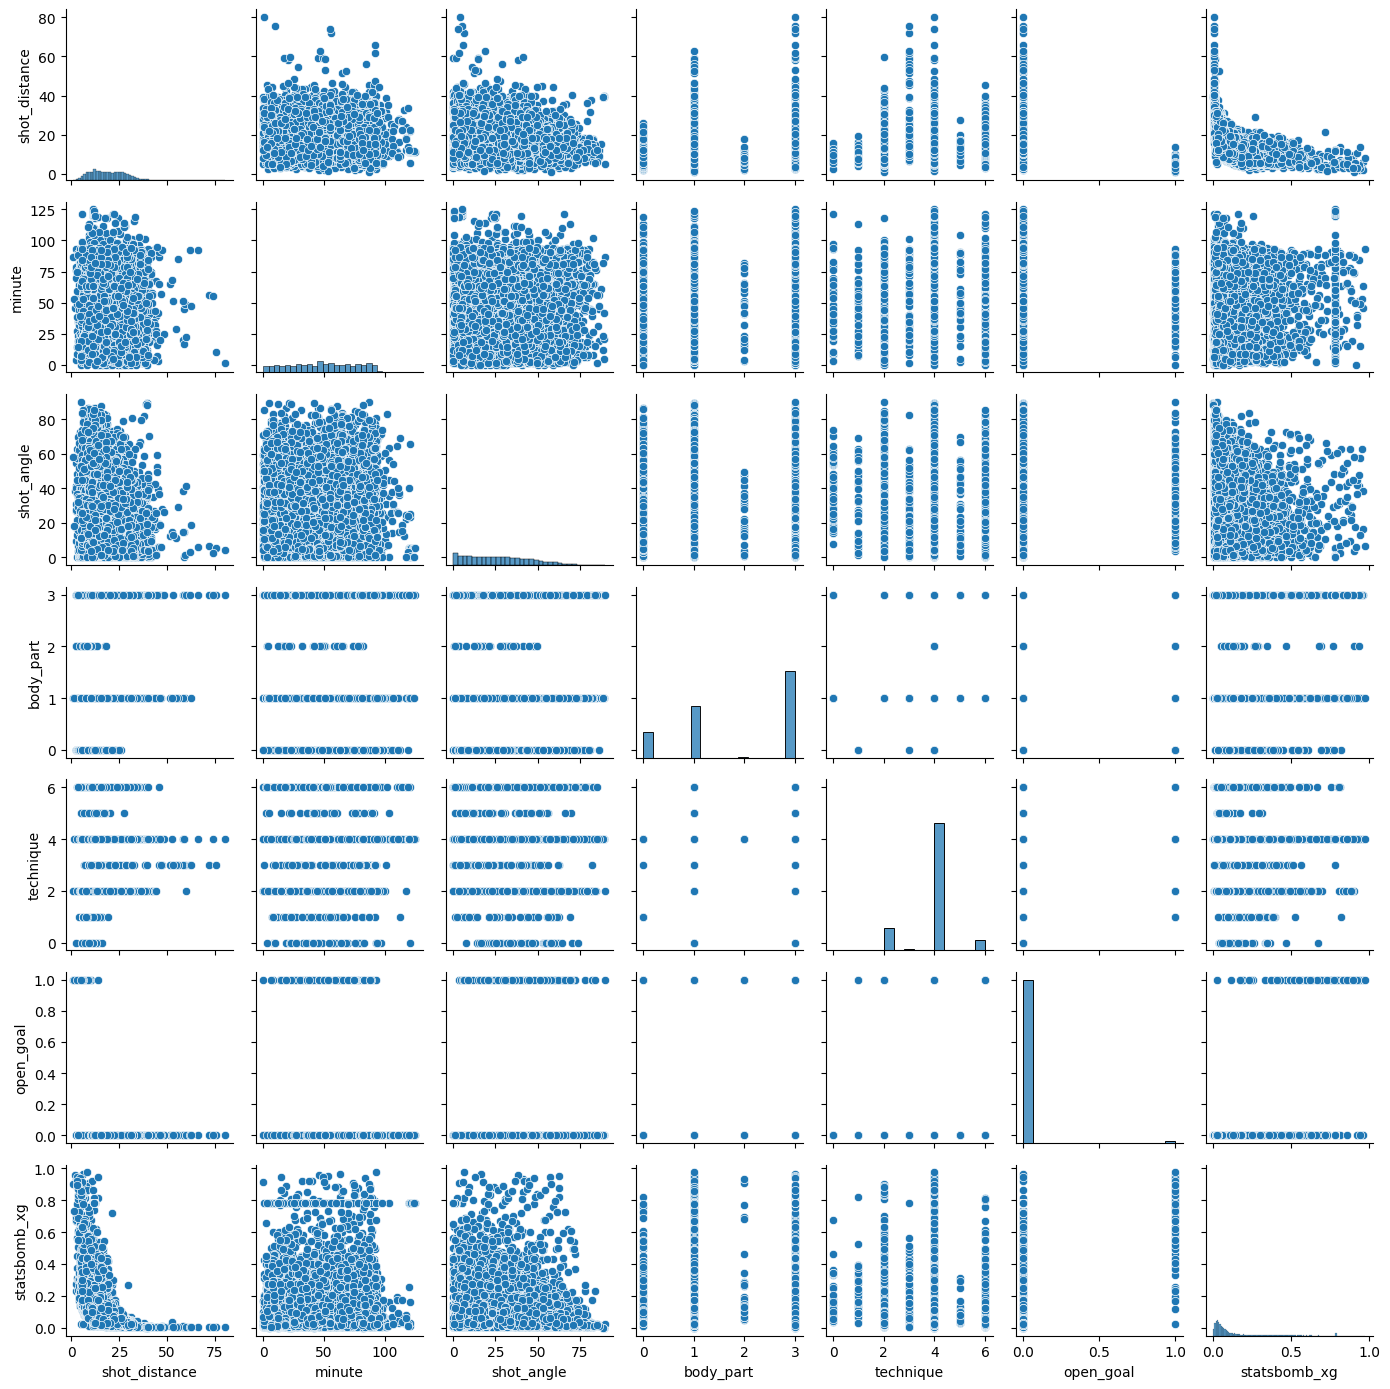

In [251]:
cols=['shot_distance','minute',
    'shot_angle', 'body_part',
    'technique', 'open_goal','statsbomb_xg',]
sns.pairplot(df[cols], size=2)
plt.tight_layout()
plt.show()


Com podem veure la distància del xut manté una relació exponencial amb els expected goals. Concretament, la relació és de statsbomb_xg=e^(-shot_distance). Per tant provarem de fer una transformació del tipus: f(x)=-log(x) per treballar amb unes dades que s'adaptin millor a una possible regressió.

C:\Users\eloim\anaconda3\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


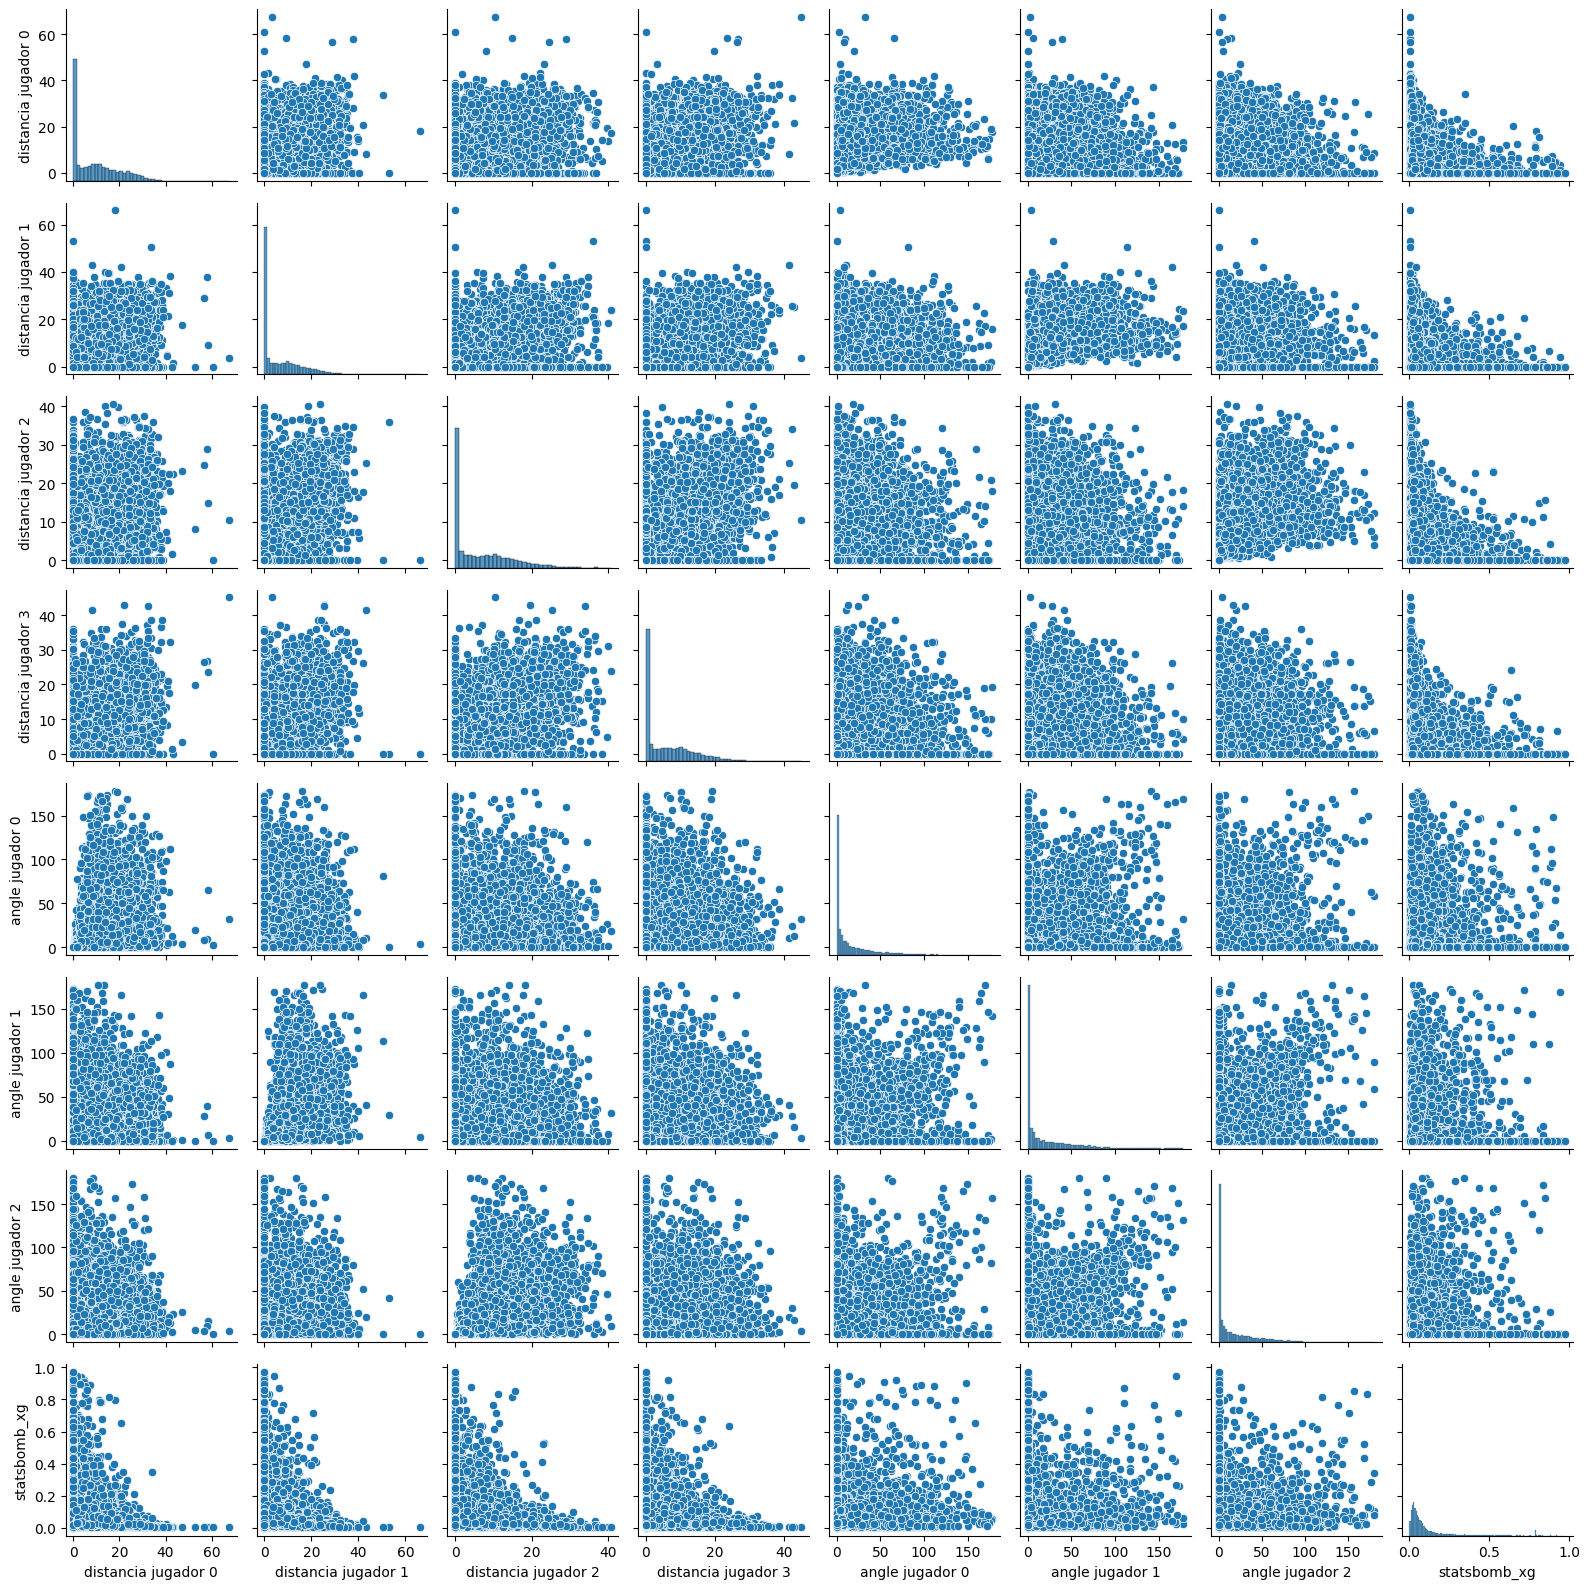

In [252]:
cols=['distancia jugador 0','distancia jugador 1',
    'distancia jugador 2', 'distancia jugador 3',
    'angle jugador 0', 'angle jugador 1','angle jugador 2','statsbomb_xg']
sns.pairplot(df[cols], size=2)
plt.tight_layout()
plt.show()

In [253]:
df['shot_distance']=np.log(df['shot_distance'])
print(df['shot_distance'].head(10))
df['distancia jugador 0']=np.log(df['distancia jugador 0'])
df['distancia jugador 1']=np.log(df['distancia jugador 1'])
df['distancia jugador 2']=np.log(df['distancia jugador 2'])
df['distancia jugador 3']=np.log(df['distancia jugador 3'])
df['distancia jugador 4']=np.log(df['distancia jugador 4'])
df['distancia jugador 5']=np.log(df['distancia jugador 5'])
df['distancia jugador 6']=np.log(df['distancia jugador 6'])
df['distancia jugador 7']=np.log(df['distancia jugador 7'])
df['distancia jugador 8']=np.log(df['distancia jugador 8'])


0    2.737520
1    2.701721
2    3.289473
3    2.383006
4    2.973926
5    2.815247
6    2.039954
7    3.283343
8    2.036731
9    3.001029
Name: shot_distance, dtype: float64


C:\Users\eloim\anaconda3\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Correlacions de totes les variables amb expected_goals:
event_id               0.011226
period                 0.072268
minute                 0.050020
team                  -0.014349
player                 0.022589
location              -0.140917
shot_distance         -0.584508
shot_angle            -0.112385
body_part             -0.028149
play_pattern           0.070306
technique             -0.010240
statsbomb_xg           1.000000
type                   0.246465
aerial_won            -0.014412
open_goal              0.385100
distancia jugador 0   -0.333799
angle jugador 0       -0.053362
distancia jugador 1   -0.304090
angle jugador 1       -0.090975
distancia jugador 2   -0.292606
angle jugador 2       -0.084837
distancia jugador 3   -0.274884
angle jugador 3       -0.091197
distancia jugador 4   -0.304731
angle jugador 4       -0.100142
distancia jugador 5   -0.281054
angle jugador 5       -0.112430
distancia jugador 6   -0.299886
angle jugador 6       -0.132538
distancia jugado

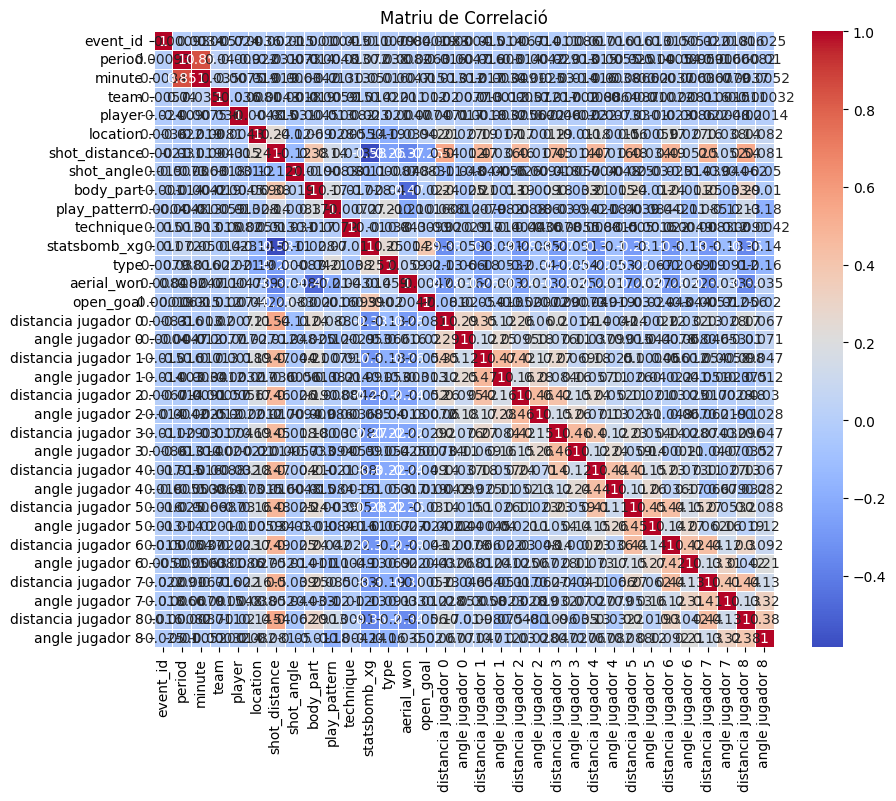

In [254]:
correlation_matrix = df.corr()

correlation_with_survived = correlation_matrix['statsbomb_xg']
print("Correlacions de totes les variables amb expected_goals:")
print(correlation_with_survived)
def show_correlation_matrix(df):
    plt.figure(figsize=(10, 8))
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Matriu de Correlació')
    plt.show()

# Fem una crida a la funció per mostrar la matriu de correlació
show_correlation_matrix(df)



In [255]:
#TO DO: EXPLICAR QUÈ ENS CARREGUEM A CONTINUACIÓ

In [256]:
df.drop('player', axis=1, inplace=True)
df.drop('event_id',axis=1, inplace=True)
df.drop('team', axis=1, inplace=True)

In [257]:
#TO DO: EXPLICAR NORMALITZACIÓ

In [258]:
"""scaler = StandardScaler()

columns_to_normalize = ['minute', 'location', 'shot_distance', 'shot_angle',
                        'distancia jugador 0', 'angle jugador 0','distancia jugador 1', 'angle jugador 1',
                        'distancia jugador 2', 'angle jugador 2','distancia jugador 3', 'angle jugador 3',
                       'distancia jugador 4', 'angle jugador 4','distancia jugador 5', 'angle jugador 5',
                        'distancia jugador 6', 'angle jugador 6','distancia jugador 7', 'angle jugador 7',
                        'distancia jugador 8', 'angle jugador 8']

df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

print(df[columns_to_normalize].head())
print(df.describe())"""
import numpy as np
from sklearn.preprocessing import StandardScaler

# Reemplazar valores infinitos por 0
df.replace([np.inf, -np.inf], 0, inplace=True)

# Normalizar las columnas seleccionadas
scaler = StandardScaler()

columns_to_normalize = ['minute', 'location', 'shot_distance', 'shot_angle',
                        'distancia jugador 0', 'angle jugador 0','distancia jugador 1', 'angle jugador 1',
                        'distancia jugador 2', 'angle jugador 2','distancia jugador 3', 'angle jugador 3',
                        'distancia jugador 4', 'angle jugador 4','distancia jugador 5', 'angle jugador 5',
                        'distancia jugador 6', 'angle jugador 6','distancia jugador 7', 'angle jugador 7',
                        'distancia jugador 8', 'angle jugador 8']

# Asegurarse de que no haya valores infinitos ni NaN antes de normalizar
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

# Imprimir los resultados de las primeras filas y estadísticas descriptivas
print(df[columns_to_normalize].head())
print(df.describe())


     minute  location  shot_distance  shot_angle  distancia jugador 0  \
0 -1.741944 -0.148700      -0.203965    1.514853            -1.208168   
1 -1.631025  0.221968      -0.274555    2.002408            -1.208168   
2 -1.261293  1.090136       0.884416   -0.875645            -0.812842   
3 -1.224319 -0.508266      -0.903020   -1.226097            -1.208168   
4 -1.150373 -0.758510       0.262198    1.240685            -0.427635   

   angle jugador 0  distancia jugador 1  angle jugador 1  distancia jugador 2  \
0        -0.661273            -1.013692        -0.658091            -1.043955   
1        -0.661273            -1.013692        -0.658091            -1.043955   
2        -0.640785            -1.013692        -0.658091            -1.043955   
3        -0.661273             0.672755        -0.032894            -1.043955   
4        -0.568272             1.145525         1.839758             0.900987   

   angle jugador 2  ...  distancia jugador 4  angle jugador 4  \
0        

In [259]:
###ENTRENAMENT MODEL#####
#Separem X i Y
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import train_test_split

target_att = 'statsbomb_xg'
attributes = [k for k in df.keys() if k!= target_att]
lr = LinearRegression(fit_intercept = True)

X = df[attributes]
y = df[[target_att]]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state=42)

lr.fit(X_train,y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

r2_train = r2_score(y_train,y_pred_train)
r2_test = r2_score(y_test,y_pred_test)

print (r2_train,r2_test)

mse_train_linear = mean_squared_error(y_train, y_pred_train)
mse_test_linear = mean_squared_error(y_test, y_pred_test)

print(f"MSE Train (Linear Regression): {mse_train_linear}")
print(f"MSE Test (Linear Regression): {mse_test_linear}")

0.5703593827547053 0.5481247326533694
MSE Train (Linear Regression): 0.009389900173851447
MSE Test (Linear Regression): 0.009596507112197129


Com podem veure, tot i ser uns resultats decents per ser el primer model que apliquem al conjunt de dades, podem veure que possiblement una regressió lineal no captura bé les relacions més complexes que podem tenir al nostre model. També podem veure que el valor del MSE és molt baix, tot i així no és tan significatiu com sembla perquè estem predint probabilitats i per tant valors entre 0 i 1, per tant és obvi que serà baix.

In [260]:
from sklearn.preprocessing import PolynomialFeatures
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

poly = PolynomialFeatures(degree=2)  
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lr = LinearRegression(fit_intercept=True)
model=lr.fit(X_train_poly, y_train)

y_pred_train = lr.predict(X_train_poly)
y_pred_test = lr.predict(X_test_poly)

r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f'R2 Train: {r2_train}, R2 Test: {r2_test}')
mse_train_linear = mean_squared_error(y_train, y_pred_train)
mse_test_linear = mean_squared_error(y_test, y_pred_test)

print(f"MSE Train (Linear Regression): {mse_train_linear}")
print(f"MSE Test (Linear Regression): {mse_test_linear}")

R2 Train: 0.8574526058582809, R2 Test: 0.7738120382704139
MSE Train (Linear Regression): 0.0031154079649531982
MSE Test (Linear Regression): 0.004803569790789813


Els resultats indiquen que el model de regressió polinòmica de grau 2 està funcionant bé. Els valors de R² són elevats tant en entrenament com en prova, mostrant que el model és capaç de capturar la major part de la variabilitat en les dades. A més, el MSE baix en ambdós conjunts suggereix que el model fa prediccions precises tant per les dades d'entrenament com per les de prova.

Aquestes mètriques indiquen que el model té una bona capacitat de predicció i generalització, i que la transformació polinòmica de grau 2 ha estat una bona elecció per ajustar la relació entre les característiques i la variable objectiu (probabilitat de gol).

Com podem veure és molt millor que la regressió lineal perquè té un millor r2 score i MSE, a més tot i que sembla que la diferència entre train i test és més gran no és prou significativa com per considerar l'existència d'overfitting.

In [ ]:
coefs = np.abs(lr.coef_[0]) #Mirem la contribucio de cada element
coefs = coefs/np.sum(coefs)

plt.bar(np.arange(len(coefs)),coefs)
plt.xticks(np.arange(len(coefs)),attributes,rotation = 45)
plt.show()

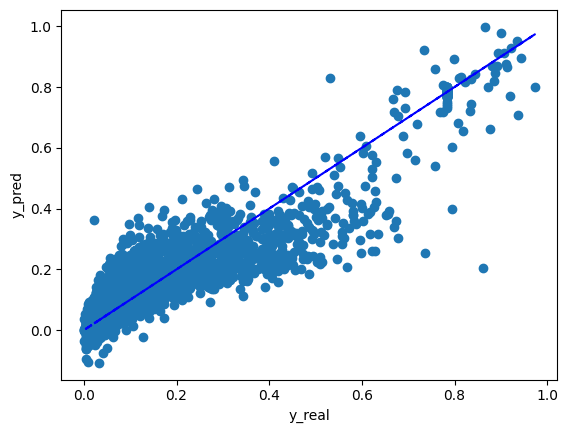

NameError: name 'y_pred' is not defined

In [261]:
plt.scatter(y_train,y_pred_train)
plt.plot(y,y,'--',c = 'blue')
plt.xlabel('y_real')
plt.ylabel('y_pred')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear un boxplot per cada característica
plt.figure(figsize=(12, 8))
sns.boxplot(data=df[columns_to_normalize])
plt.title('Boxplot per a les característiques')
plt.xticks(rotation=90)
plt.show()


Com podem veure en aquest Boxplot tenim una quantitat considerable d'outliers als angles dels rivals. Els outliers es mostren com a punts situats fora de les "caixes" (els límits de la caixa són el quartil 1 i quartil 3, i les línies de la caixa mostren el rang interquartil).

Tot seguit aplicarem IQR (Rang interquartil): El mètode IQR detecta outliers com aquells punts que es troben fora del rang definit pels quartils 1 i 3 (Q1 - 1.5IQR, Q3 + 1.5IQR).

In [ ]:
Q1 = df[columns_to_normalize].quantile(0.25)
Q3 = df[columns_to_normalize].quantile(0.75)
IQR = Q3 - Q1

# Detectar outliers utilitzant IQR
outliers = ((df[columns_to_normalize] < (Q1 - 1.5 * IQR)) | (df[columns_to_normalize] > (Q3 + 1.5 * IQR)))
print(f'Número d\'outliers per columna:\n{outliers.sum()}')


In [ ]:
#TO DO: EXPLICAR RANSAC

In [ ]:
from sklearn.linear_model import RANSACRegressor


X = df[attributes]
y = df[[target_att]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)


ransac = RANSACRegressor(max_trials=100, min_samples=200, 
                         loss='squared_error', residual_threshold=0.8, random_state=42)
ransac.fit(X_train_poly, y_train)

y_pred_train = ransac.predict(X_train_poly)
y_pred_test = ransac.predict(X_test_poly)


r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print(f'R2 Train: {r2_train}, R2 Test: {r2_test}')
mse_train_ransac = mean_squared_error(y_train, y_pred_train)
mse_test_ransac = mean_squared_error(y_test, y_pred_test)
print(f"MSE Train (RANSAC): {mse_train_ransac}")
print(f"MSE Test (RANSAC): {mse_test_ransac}")


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

threshold = 0.50 
y_binary = (df['statsbomb_xg'] > threshold).astype(int)  # Considera gol si P(Y=1) > 0.5

X = df[attributes]  
y = y_binary  

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de regresión logística
logreg = LogisticRegression()

# Ajustar el modelo
logreg.fit(X_train, y_train)

# Obtener las probabilidades predichas (P(y=1 | x))
y_prob_train = logreg.predict_proba(X_train)[:, 1]  
y_prob_test = logreg.predict_proba(X_test)[:, 1]   

r2_train = r2_score(y_train, y_prob_train)
r2_test = r2_score(y_test, y_prob_test)

print(f'R² Train: {r2_train}')
print(f'R² Test: {r2_test}')

print("Probabilidades de gol (Train):", y_prob_train[:5])
print("Probabilidades de gol (Test):", y_prob_test[:5])



In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Separar en características (X) y objetivo (y)
X = df[attributes]  # Asegúrate de que 'attributes' contiene las variables relevantes
y = df[[target_att]]  # Esto sigue siendo la probabilidad de gol (statsbomb_xg)

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo de Árbol de Decisión para regresión
decision_tree = DecisionTreeRegressor(max_depth=15, min_samples_split=50, min_samples_leaf=20, random_state=42)

# Ajustar el modelo al conjunto de entrenamiento
decision_tree.fit(X_train, y_train)

# Predecir en el conjunto de entrenamiento y prueba
y_pred_train = decision_tree.predict(X_train)
y_pred_test = decision_tree.predict(X_test)

# Evaluar el modelo con R²
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

# Evaluar el modelo con MSE
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

# Mostrar los resultados
print(f'R² Train: {r2_train}')
print(f'R² Test: {r2_test}')
print(f'MSE Train: {mse_train}')
print(f'MSE Test: {mse_test}')
